# Antibiotic Resistance Gene Origin Predictor

A machine-learning based bioinformatics tool for predicting the origin of antibiotic resistance genes using codon usage bias analysis.

## Project Overview

**Problem:** Antibiotic resistance genes spread rapidly through _horizontal gene transfer (HGT)_, making it crucial to track their origins and transmission routes.

**Solution:** Uses machine-learning to analyze codon usage patterns and predict whether resistance genes are native to an organism or were horizontally transferred.

**Impact:** Helps understand resistance gene transmission, track outbreak sources, and inform antibiotic stewardship strategies.

---

## Scientific Background

### Codon Usage Bias

Different organisms preferentially use certain synonymous codons over others. These preferences are shaped by:

- tRNA abundance
- Mutation biases
- Selection for translation efficiency
- GC content constraints

### Horizontal Gene Transfer Detection

When genes are transferred between organisms, they often retain the codon usage signature of their source organism, making them detectable through statistical analysis


## Create Sample Data

In [4]:
import os
import numpy as np

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [5]:
def create_demo_data():
    """Create demo dataset with synthetic genes"""

    # Create data directory
    os.makedirs('data', exist_ok=True)

    # Known codon usage biases
    # E. coli prefers: CTG (Leu), GCG (Ala), GCG (Arg) etc
    # Transferred genes often have different biases
    native_codons = ['CTG', 'GCG', 'CGC', 'GAA', 'GTG', 'ACC', 'AAC', 'GAC']
    transferred_codons = ['CTA', 'GCA', 'CGA', 'GAG', 'GTA', 'ACA', 'AAT', 'GAT']

    def generate_gene(codon_preference, length=600):
        """Generate synthetic gene with codon bias"""
        gene = 'ATG'    # Start Codon
        while len(gene) < length - 3:
            codon = np.random.choice(codon_preference)
            gene += codon
        gene += 'TAA'   # Stop Codon
        return gene

    # Generate native genes (100 samples)
    native_records = []
    for i in range(100):
        seq = generate_gene(native_codons)
        record = SeqRecord(
            Seq(seq),
            id=f"native_{i+1}",
            description=f"Native housekeeping gene {i+1} [E. coli]"
        )
        native_records.append(record)

    # Generate transferred genes (100 samples)
    transferred_records = []
    for i in range(100):
        seq = generate_gene(transferred_codons)
        record = SeqRecord(
            Seq(seq),
            id=f"resistance_{i+1}",
            description=f"Transferred resistance gene {i+1}",
        )
        transferred_records.append(record)

    # Save FASTA files
    SeqIO.write(native_records, 'data/native_genes.fasta', 'fasta')
    SeqIO.write(transferred_records, 'data/transferred_genes.fasta', 'fasta')

    return 100, 100

In [6]:
print("\n[1/5] Creating demo dataset...")
create_demo_data()


[1/5] Creating demo dataset...


(100, 100)

## Feature Extraction

In [7]:
# Genetic code
GENETIC_CODE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [12]:
from collections import Counter

In [8]:
def extract_features(sequence):
    """Extract codon usage features from sequence"""
    features = {}

    # Extract codons
    codons = [sequence[i:i+3] for i in range(0, len(sequence) - 2, 3)]
    valid_codons = [c for c in codons if len(c) == 3 and c in GENETIC_CODE and GENETIC_CODE[c] != '*']
    if not valid_codons:
        return None
    
    # Codon frequencies
    codon_counts = Counter(valid_codons)
    total = len(valid_codons)

    for codon in GENETIC_CODE.keys():
        if GENETIC_CODE[codon] != '*':
            features[f'codon_{codon}'] = codon_counts[codon] / total if total > 0 else 0

    # GC content
    gc_count = sequence.count('G') + sequence.count('C')
    features['GC_content'] = gc_count / len(sequence) if len(sequence) > 0 else 0

    # GC3 (third position)
    third_pos = sequence[2::3]
    gc3_count = third_pos.count('G') + third_pos.count('C')
    features['GC3_content'] = gc3_count / len(third_pos) if len(third_pos) > 0 else 0

    return features

In [14]:
import pandas as pd

In [9]:
def load_and_extract(fasta_file, label):
    """Load FASTA file and extract features"""

    all_features = []

    for record in SeqIO.parse(fasta_file, 'fasta'):
        features = extract_features(str(record.seq))
        if features:
            features["gene_id"] = record.id
            features["label"] = label
            all_features.append(features)

    return pd.DataFrame(all_features)

In [16]:
def load_dataset():
    """Load and prepare dataset"""

   # Load native genes
    df_native = load_and_extract('data/native_genes.fasta', label=0)
    print(f"   ✓ Loaded {len(df_native)} native genes")
    
    # Load resistance genes
    df_resistance = load_and_extract('data/transferred_genes.fasta', label=1)
    print(f"   ✓ Loaded {len(df_resistance)} resistance genes")
    
    # Combine
    df = pd.concat([df_native, df_resistance], ignore_index=True)
    
    print(f"   ✓ Total dataset: {len(df)} genes")
    print(f"   ✓ Features extracted: {len(df.columns) - 2}")  # Minus gene_id and label
    
    return df

In [20]:
print("\n[2/5] Loading and processing data...")
df = load_dataset()
df.head()


[2/5] Loading and processing data...
   ✓ Loaded 100 native genes
   ✓ Loaded 100 resistance genes
   ✓ Total dataset: 200 genes
   ✓ Features extracted: 63


,codon_TTT,codon_TTC,codon_TTA,codon_TTG,codon_TCT,codon_TCC,codon_TCA,codon_TCG,codon_TAT,codon_TAC,...,codon_GAA,codon_GAG,codon_GGT,codon_GGC,codon_GGA,codon_GGG,GC_content,GC3_content,gene_id,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.100503,0.0,0.0,0.0,0.0,0.0,0.651667,0.895,native_1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.125628,0.0,0.0,0.0,0.0,0.0,0.658333,0.870,native_2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.115578,0.0,0.0,0.0,0.0,0.0,0.666667,0.880,native_3,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090452,0.0,0.0,0.0,0.0,0.0,0.675000,0.905,native_4,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.130653,0.0,0.0,0.0,0.0,0.0,0.650000,0.865,native_5,0


## Train Model

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [22]:
def train_rf_model(df):
    """Train Random Forest Classifier"""

    # Prepare features
    X = df.drop(['gene_id', 'label'], axis=1)
    y = df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=123
    )

    print(f"   ✓ Training set: {len(X_train)} samples")
    print(f"   ✓ Test set: {len(X_test)} samples")

    # Train Random Forest Model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=123,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate
    print("\n   Classification Report:")
    print("   " + "-"*50)
    report = classification_report(y_test, y_pred, target_names=['Native', 'Transferred'])
    for line in report.split('\n'):
        print(f"   {line}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\n   ROC-AUC Score: {roc_auc:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"   Cross-validation F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    return model, X, y, X_test, y_test, y_pred


In [26]:
print("\n[3/5] Training model...")
model, X, y, X_test, y_test, y_pred = train_rf_model(df)


[3/5] Training model...
   ✓ Training set: 160 samples
   ✓ Test set: 40 samples

   Classification Report:
   --------------------------------------------------
                 precision    recall  f1-score   support
   
         Native       1.00      1.00      1.00        20
    Transferred       1.00      1.00      1.00        20
   
       accuracy                           1.00        40
      macro avg       1.00      1.00      1.00        40
   weighted avg       1.00      1.00      1.00        40
   

   ROC-AUC Score: 1.0000
   Cross-validation F1: 1.0000 (+/- 0.0000)


## Visualization

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
def create_visualization(model, X, y_test, y_pred):
    """Create Visualization"""

    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved feature_importance.png")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Native', 'Transferred'], yticklabels=['Native', 'Transferred'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved confusion_matrix.png")

    plt.close('all')

    return feature_importance


[4/5] Creating visualizations...


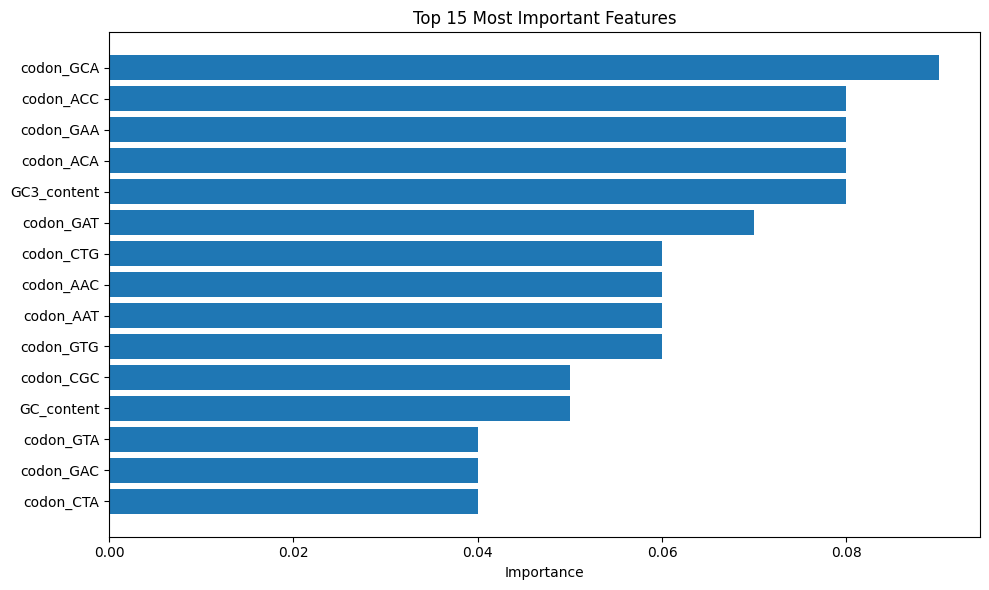

   ✓ Saved feature_importance.png


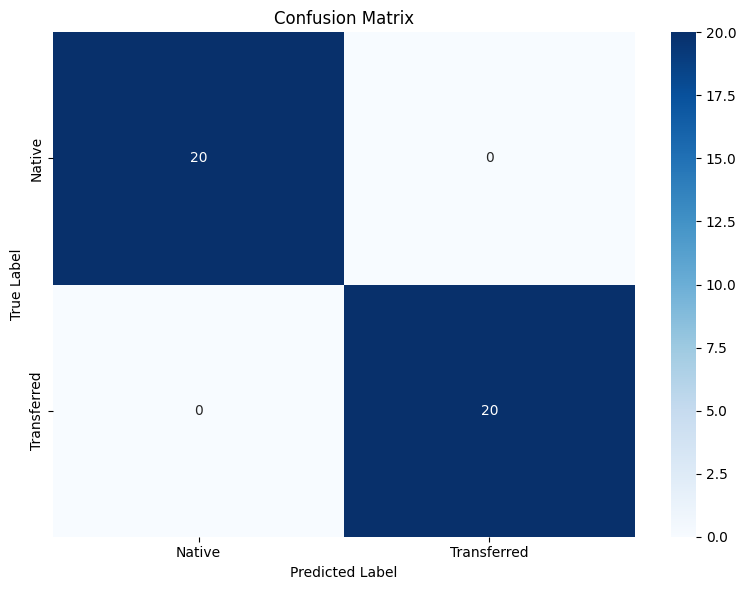

   ✓ Saved confusion_matrix.png


In [31]:
print("\n[4/5] Creating visualizations...")
feature_importance = create_visualization(model, X, y_test, y_pred)

## Save Model

In [32]:
import pickle

In [33]:
def save_model(model):
    """Save trained model"""
    with open('model.pkl', 'wb') as file:
        pickle.dump(model, file)
    print("   ✓ Model saved as argop_model.pkl")


In [34]:
print("\n[5/5] Saving model...")
save_model(model)


[5/5] Saving model...
   ✓ Model saved as argop_model.pkl


## Prediction Example

In [35]:
def predict_example(model, X):
    """Example prediction on new sequence"""

    # Example: beta-lactamase gene (typically transferred)
    example_seq = "ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGCGGTAAGATCCTTGAGAGTTTTCGCCCCGAAGAACGTTTTCCAATGATGAGCACTTTTAAAGTTCTGCTATGTGGCGCGGTATTATCCCGTATTGACGCCGGGCAAGAGCAACTCGGTCGCCGCATACACTATTCTCAGAATGACTTGGTTGAGTACTCACCAGTCACAGAAAAGCATCTTACGGATGGCATGACAGTAAGAGAATTATGCAGTGCTGCCATAACCATGAGTGATAACACTGCGGCCAACTTACTTCTGACAACGATCGGAGGACCGAAGGAGCTAACCGCTTTTTTGCACAACATGGGGGATCATGTAACTCGCCTTGATCGTTGGGAACCGGAGCTGAATGAAGCCATACCAAACGACGAGCGTGACACCACGATGCCTGTAGCAATGGCAACAACGTTGCGCAAACTATTAACTGGCGAACTACTTACTCTAGCTTCCCGGCAACAATTAATAGACTGGATGGAGGCGGATAAAGTTGCAGGACCACTTCTGCGCTCGGCCCTTCCGGCTGGCTGGTTTATTGCTGATAAATCTGGAGCCGGTGAGCGTGGGTCTCGCGGTATCATTGCAGCACTGGGGCCAGATGGTAAGCCCTCCCGTATCGTAGTTATCTACACGACGGGGAGTCAGGCAACTATGGATGAACGAAATAGACAGATCGCTGAGATAGGTGCCTCACTGATTAAGCATTGGTAA"
   
    # Extract features
    features = extract_features(example_seq)
    if features:
        # Convert to DataFrame with same columns as training
        feature_df = pd.DataFrame([features])
        feature_df = feature_df.reindex(columns=X.columns, fill_value=0)

        # Predict
        prediction = model.predict(feature_df)[0]
        probabilities = model.predict_proba(feature_df)[0]

        print(f"\nSequence length: {len(example_seq)} bp")
        print(f"Prediction: {'TRANSFERRED (Resistance Gene)' if prediction == 1 else 'NATIVE (Housekeeping)'}")
        print(f"Confidence: {max(probabilities):.1%}")
        print(f"\nProbabilities:")
        print(f"  Native: {probabilities[0]:.1%}")
        print(f"  Transferred: {probabilities[1]:.1%}")


In [36]:
predict_example(model, X)


Sequence length: 861 bp
Prediction: TRANSFERRED (Resistance Gene)
Confidence: 57.0%

Probabilities:
  Native: 43.0%
  Transferred: 57.0%
